# Firing-rate model of self-sustained persistent activity

Consider one excitatory population of neurons, with its firing rate $r$ as a function of input current $I$ given by

\begin{equation}
r = F(I) = \frac{aI − b}{1 − e^{(−d(aI − b))}}
\end{equation}

which captures the current-frequency function of a leaky integrate-and-fire neuron, driven by a noisy input. Because of the recurrent excitation, the current $I$ includes an external input and a recurrent input from the same neural population. The latter is described by a synaptic drive variable $s$ that obeys

\begin{equation}
\frac{ds}{dt} = F(I)\gamma(1 − s) − \frac{s}{\tau_s}
\end{equation}

where $I = g_Es + I_{ext}$ and and $I_{ext} = I_0 + I_1(t)$, where $I_0$ is a fixed baseline input that does not change and $I_1(t)$ represents brief applied input pulses. The synaptic time constant $\tau_s$ = 100 ms for slow, NMDA receptor dependent synaptic excitation.

In [1]:
# Import relevant modules
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint

# Define firing-rate model object

In [2]:
class firing_rate_network:
    # parameter initialization
    def __init__(self, a=270, b=108, d=.154, gamma=.64, tau_s=.1, g_E=.28, I_o=.32):
        self.a = a              # in Hz/nA
        self.b = b              # Hz
        self.d = d              # in s
        self.gamma = gamma
        self.tau_s = tau_s      # in s
        self.g_E = g_E          # in nA
        self.I_o = I_o          # in nA
        
    # compute network firing rate
    def rate(self, s, I_1, g_E=None):
        if  g_E==None:
            g_E = self.g_E
        I_ext = self.I_o + I_1
        I = g_E * s + I_ext
        r = (self.a * I - self.b) / (1 - math.exp(-self.d * ( self.a * I - self.b )))
        return r
    
    # firing rate network model simulations with odeint
    def modelODE(self, s, t, I_1, g_E=None):
        r = self.rate(s, I_1, g_E)
        dsdt = (r*self.gamma*(1 - s))-(s/self.tau_s)
        return dsdt
    
    # firing rate network model simulations using Euler approximation
    def simulation(self, I_0, I_1, I_2, g_E=None, t=15, t1=2, t2=8, pulse_t=.3, s=0):
        dt = self.tau_s/10
        T = np.arange(0, t, dt)
        S = []
        for t in T:
            if t > t1 and t < t1+pulse_t:
                r = network.rate(s, I_1, g_E)
            elif t > t2 and t < t2+pulse_t:
                r = network.rate(s, I_2, g_E)
            else:   
                r = network.rate(s, I_0, g_E)

            dsdt = (r*self.gamma*(1 - s))-(s/self.tau_s)
            s += dsdt * dt
            S.append(s)
        return S, T, t1, t2
    
    # geometrically calculate the fixed points (both stable and unstable)
    def geometry_fixed_points(self, S, I_0, g_E=None, eps=1e-4):
        W = []
        G = []
        fixed_points = []
        
        for s in S:
            r = self.rate(s, I_0, g_E)
            W_s = 1 / ( 1 + 1/ (self.gamma * self.tau_s * r) )
            W.append(W_s)

            G_s = s
            G.append(G_s)

            if np.abs(G_s - W_s) < eps:
                fixed_points.append(s)
            
        return W, G, fixed_points

# 1) Initiate and simulate dynamics firing-rate model
Simulate firing-rate network with parameters $a=270Hz/nA, b=108Hz, d=.154s, \gamma=.64, \tau_s=.1s, g_E=.28nA, I_0=.32nA$. We can track the evolution of the rate for different initial conditions of $s$.

## a) Stable solutions
In the below graph we can see that this system has at least two stable solutions for this given set of parameters. Depending on the initial condition of $s$ the system converges to one steady state solution. For initial condition $s=0$ the system evolves to a sustained firing rate of $0.12Hz$. 

In [3]:
network = firing_rate_network()

In [4]:
t = np.linspace(0, 5, 1000)
dynamics = []
I_1 = 0
S_o = np.array([0, .2, 0.2432432432432432, .3, .8])
simulationM = np.zeros((len(S_o), len(t)))
cnt =0

for s in S_o:
    simulationM[cnt, :] = odeint(network.modelODE, s, t, args = (I_1,)).T
    cnt +=1
    
print('Firing rate at first steady state '+str(simulationM[0, -1]))
print('Firing rate at second steady state '+str(simulationM[4, -1]))

Firing rate at first steady state 0.11955435356369061
Firing rate at second steady state 0.6277435335392857


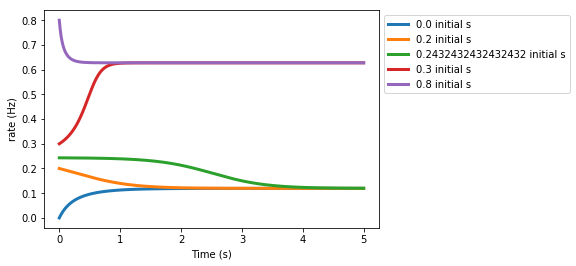

In [5]:
plt.plot(t, simulationM.T, lw= 3)
plt.ylabel('rate (Hz)')
plt.xlabel('Time (s)')
plt.legend([str(i)+' initial s' for i in S_o], bbox_to_anchor=(1, 1));

## b) Bi-stable dynamic system
Depending on the parameter choice, dynamic systems can express different fixed points. If we perturbe the system one can push the system to transition between different stable solutions. Below, we see that if we provid the system with a external current input of high enough amplitude we can make the system switch between stable positions. If the system is at its low firing rate stable point ($r = 0.12Hz$) a pulse of more that $I_1 = 0.0103nA$ is enough to drive it to the other stable solution. If the system is in the high firing rate stable point ($r = 0.63Hz$) a pulse of negative amplitede and more that $I_1 = -0.029nA$ is enough to switch to the other stable solution.

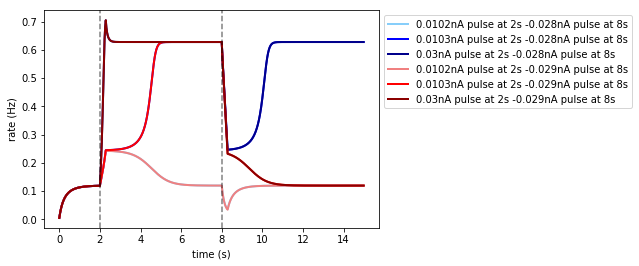

In [6]:
I_0 = 0
I_1s = np.array([.0102, .0103, .03])
I_2s = np.array([-.028, -.029])

cmap = ['lightskyblue', 'blue', 'darkblue', 'lightcoral', 'red', 'darkred']
i = 0
cond = []

for I_2 in I_2s:
    for I_1 in I_1s:
        S, T, t1, t2 = network.simulation(I_0, I_1, I_2)
        plt.plot(T, S, lw=2, c=cmap[i])
        i +=1
        cond.append([str(I_1), str(I_2)])

plt.axvline(t1, ls='--', c='k', alpha=.5)
plt.axvline(t2, ls='--', c='k', alpha=.5)
plt.xlabel('time (s)')
plt.ylabel('rate (Hz)')

plt.legend([i[0]+'nA pulse at '+str(t1)+'s '+i[1]+'nA pulse at '+str(t2)+'s' for i in cond], bbox_to_anchor=(1, 1));

# 2) Solving for fixed points geometrically
Fixed points or steady state solutions happend when there is in change in the value of a variable of interest over time. Thus, we can define for or system as:

\begin{equation}
0 = \frac{ds}{dt} = F(I)\gamma(1 − s) − \frac{s}{\tau_s} = F(I)\gamma - s( F(I)\gamma + \frac{1}{\tau_s} )
\end{equation}

Rearraging:
\begin{equation}
 F(I)\gamma = s( F(I)\gamma + \frac{1}{\tau_s} )
\end{equation}

\begin{equation}
 s = \frac{F(I)\gamma}{( F(I)\gamma + \frac{1}{\tau_s} )} = \frac{F(g_Es + I_{ext})\gamma}{( F(g_Es + I_{ext})\gamma + \frac{1}{\tau_s} )}
\end{equation}

Now, we can define the first term as $G(s)$ and the second one as $W(s)$. A given $s$ is a fixed point $s_{\inf}$ if $G(s) = W(s)$. We can now draw both functions and find the intersects to solve for the fixed points.

In the graph below, we see that this system has three fixed points: two of them we already predicted with our simulations and another unstable fixed point in between.

['Fixed point at s=0.1195195195195195', 'Fixed point at s=0.2432432432432432', 'Fixed point at s=0.6276276276276276']


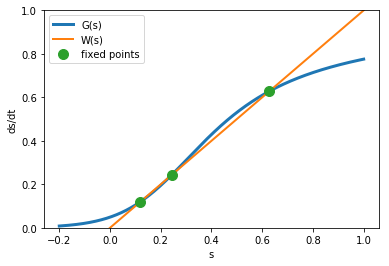

In [7]:
S_ss = np.linspace(-.2, 1, 1000)
W, G, fixed_points = network.geometry_fixed_points(S_ss, I_0)

plt.plot(S_ss, W, lw = 3)
plt.plot(S_ss, G, lw = 2)
plt.plot(fixed_points, fixed_points, 'o', ms= 10)
plt.ylim([0, 1])
plt.ylabel('ds/dt')
plt.xlabel('s')
plt.legend(['G(s)', 'W(s)', 'fixed points']);

print(['Fixed point at s='+str(i) for i in fixed_points])

## b) Evolution of fixed points for different external inputs
Using this geometric way of finding fixed points, we can now predict what solution the system will converge to for different input parameters. 

In the graph below we see that the system has only one stable solution at the high firing rate ($r = 0.63Hz$) for an external input of $I_1 = 0.0103nA$, validating the prediction we made before where a pulse of this magnitude pushes the dynamic system to the other stable solution. Similarly, for a negative input of $I_1 = -0.029nA$ the system only exhibits one stable solution at the low firing rate ($r = 0.12Hz$).

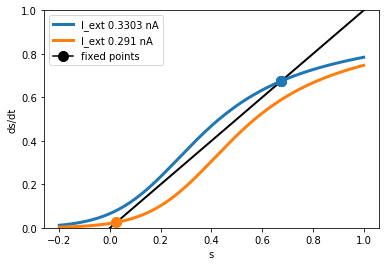

In [8]:
S_ss = np.linspace(-.2, 1, 10000)
Is = np.array([.0103, -.029])
i =0
cmap = plt.get_cmap("tab10")

plt.plot([], [], color=cmap(0), lw= 3)
plt.plot([], [], color=cmap(1), lw= 3)
plt.plot([], [], color='k', marker='o', ms= 10)

plt.plot(S_ss, S_ss, lw = 2, c='k') # note that S_ss is equal to G(s)

for I in Is:
    W, G, fixed_points = network.geometry_fixed_points(S_ss, I)

    plt.plot(S_ss, W, lw = 3, c=cmap(i) )
    plt.plot(fixed_points, fixed_points, 'o', ms= 10, c=cmap(i) )
    i +=1

plt.ylim([0, 1])
plt.ylabel('ds/dt')
plt.xlabel('s')
plt.legend(['I_ext '+str(Is[0]+network.I_o)+' nA', 'I_ext '+str(Is[1]+network.I_o)+' nA', 'fixed points']);

# 3) Evolution of fixed points for different values of recurrent connectivity 
Now we are going to explore the effect of recurrent connectivity $g_E$ on the system.

## a) Decreasing recurrent input
In the graphs below we can see that for decreasing values of $g_E$ the network exhibits lower stable firing rates. For a critical value of $g_E=< 0.26nA$ the system is no longer able to sustain the high firing rate state, regardless of how strong the input current is or initial conditions, as we see in the simulations. This result is consistent with the fixed points that we discover solving the system geometrically. Here, we see that for that critical value of $g_E< 0.26nA$ the system only has a stable solution at the lower firing rate. 

## a) Increasing recurrent input
If we repeat the same experiment but increasing the magnitide of the recurrent input, we find that the stable solutions also scale and that for a critical value of $g_E=> 0.3nA$ the system only has a stable solution at the higher firing rate, as shown by the simulation and the fixed points.

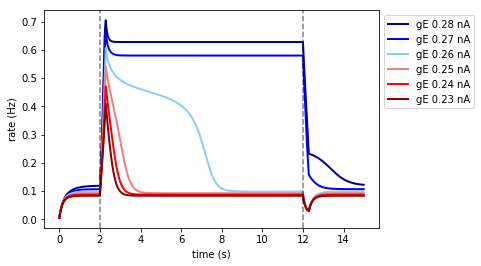

In [9]:
g_Es = np.arange(.28, 0.23, -.01)

cmap = ['darkblue', 'blue', 'lightskyblue', 'lightcoral', 'red', 'darkred']
i = 0
cond = []

for g_E in g_Es:
    S, T, t1, t2 = network.simulation(I_0=0, I_1=.03, I_2=-.029, g_E=g_E, t2= 12)
    plt.plot(T, S, lw=2, c=cmap[i])
    i +=1


plt.axvline(t1, ls='--', c='k', alpha=.5)
plt.axvline(t2, ls='--', c='k', alpha=.5)
plt.xlabel('time (s)')
plt.ylabel('rate (Hz)')

plt.legend(['gE '+str(round(i, 2))+' nA' for i in g_Es], bbox_to_anchor=(1, 1));

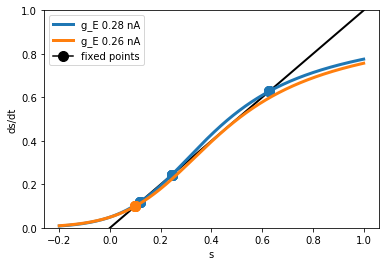

In [10]:
S_ss = np.linspace(-.2, 1, 10000)
g_Es = np.array([.28, .26])
i =0
cmap = plt.get_cmap("tab10")

plt.plot([], [], color=cmap(0), lw= 3)
plt.plot([], [], color=cmap(1), lw= 3)
plt.plot([], [], color='k', marker='o', ms= 10)

plt.plot(S_ss, S_ss, lw = 2, c='k') # note that S_ss is equal to G(s)

for g_E in g_Es:
    W, G, fixed_points = network.geometry_fixed_points(S_ss, 0, g_E= g_E)

    plt.plot(S_ss, W, lw = 3, c=cmap(i) )
    plt.plot(fixed_points, fixed_points, 'o', ms= 10, c=cmap(i) )
    i +=1

plt.ylim([0, 1])
plt.ylabel('ds/dt')
plt.xlabel('s')
plt.legend(['g_E '+str(g_Es[0])+' nA', 'g_E '+str(g_Es[1])+' nA', 'fixed points']);

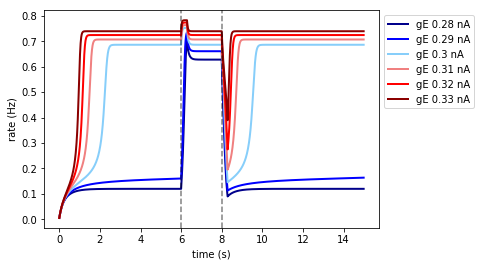

In [11]:
g_Es = np.arange(.28, 0.34, .01)

cmap = ['darkblue', 'blue', 'lightskyblue', 'lightcoral', 'red', 'darkred']
i = 0
cond = []

for g_E in g_Es:
    S, T, t1, t2 = network.simulation(I_0=0, I_1=.03, I_2=-.05, g_E=g_E, t1= 6)
    plt.plot(T, S, lw=2, c=cmap[i])
    i +=1


plt.axvline(t1, ls='--', c='k', alpha=.5)
plt.axvline(t2, ls='--', c='k', alpha=.5)
plt.xlabel('time (s)')
plt.ylabel('rate (Hz)')

plt.legend(['gE '+str(round(i, 2))+' nA' for i in g_Es], bbox_to_anchor=(1, 1));

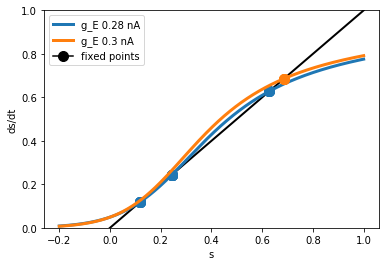

In [12]:
S_ss = np.linspace(-.2, 1, 10000)
g_Es = np.array([.28, .3])
i =0
cmap = plt.get_cmap("tab10")

plt.plot([], [], color=cmap(0), lw= 3)
plt.plot([], [], color=cmap(1), lw= 3)
plt.plot([], [], color='k', marker='o', ms= 10)

plt.plot(S_ss, S_ss, lw = 2, c='k') # note that S_ss is equal to G(s)

for g_E in g_Es:
    W, G, fixed_points = network.geometry_fixed_points(S_ss, 0, g_E= g_E)

    plt.plot(S_ss, W, lw = 3, c=cmap(i) )
    plt.plot(fixed_points, fixed_points, 'o', ms= 10, c=cmap(i) )
    i +=1

plt.ylim([0, 1])
plt.ylabel('ds/dt')
plt.xlabel('s')
plt.legend(['g_E '+str(g_Es[0])+' nA', 'g_E '+str(g_Es[1])+' nA', 'fixed points']);